In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import torch
import tqdm

from kernels.data import Dataset
from kernels.pytorch.cross_entropy import cross_entropy
from kernels.train import train
from kernels.transformer import Transformer

## Data

In [15]:
DATA_DIR = Path("/home/samgd/Code/cs336_assign2/kernels/data/owt/tokens/")
TRAIN_BIN = DATA_DIR / "owt_train.uint16.bin"
VALID_BIN = DATA_DIR / "owt_valid.uint16.bin"

SEQ_LEN = 256
BATCH_SIZE = 32
TOTAL_TOKENS = 1_000_000
EPOCHS = 10
EVAL_TOKENS = 100_000

STEPS_PER_EPOCH = TOTAL_TOKENS//(SEQ_LEN*BATCH_SIZE*EPOCHS)
EVAL_STEPS = max(EVAL_TOKENS//(SEQ_LEN*BATCH_SIZE), 1)

print(f"{STEPS_PER_EPOCH=}, {EVAL_STEPS=}")

STEPS_PER_EPOCH=12, EVAL_STEPS=12


In [16]:
train_ds = Dataset(SEQ_LEN, TRAIN_BIN)
valid_ds = Dataset(SEQ_LEN, VALID_BIN)

In [17]:
train_sampler = torch.utils.data.RandomSampler(
    train_ds, 
    replacement=True,
    num_samples=BATCH_SIZE*STEPS_PER_EPOCH,
)

train_dl = torch.utils.data.DataLoader(
    dataset=train_ds, 
    batch_size=BATCH_SIZE, 
    num_workers=1, 
    sampler=train_sampler,
    pin_memory=True,
)

In [18]:
valid_sampler = torch.utils.data.RandomSampler(
    valid_ds, 
    replacement=True,
    num_samples=BATCH_SIZE*EVAL_STEPS,
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds, 
    batch_size=BATCH_SIZE, 
    num_workers=1, 
    sampler=valid_sampler,
    pin_memory=True,
)

## Model

In [19]:
num_embeddings = tiktoken.get_encoding("gpt2").max_token_value + 1
depth = 18
d_model = 512
d_ff = int(64*((d_model*4*(2/3))//64))

n_head = d_model // 64

print(f"{num_embeddings=}, {d_model=}, {d_ff=}, {n_head=}")

num_embeddings=50257, d_model=512, d_ff=1344, n_head=8


In [20]:
model = Transformer("pytorch", num_embeddings, depth, d_model, n_head, d_ff, device="cuda")

In [21]:
num_params_mil = sum([p.numel() for p in model.parameters()]) / 1e6
print(f"{num_params_mil=:5.1f}M")

num_params_mil=107.5M


## Optim

In [22]:
lr = 3e-4

warmup_steps = 0.01*EPOCHS*STEPS_PER_EPOCH

In [23]:
opt = torch.optim.AdamW(params=model.parameters(), lr=lr)

In [24]:
warmup_sched = torch.optim.lr_scheduler.LinearLR(
    opt,
    start_factor=lr*0.01,
    end_factor=1.0,
    total_iters=warmup_steps,
)

cos_sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt,
    T_max=EPOCHS*STEPS_PER_EPOCH - warmup_steps,
    eta_min=lr*0.01,
)

lr_sched = torch.optim.lr_scheduler.SequentialLR(
    opt,
    schedulers=[warmup_sched, cos_sched],
    milestones=[warmup_steps],
)

## Training Loop

In [25]:
logs = train(model, opt, lr_sched, train_dl, valid_dl, cross_entropy, EPOCHS)

epoch 10/10, valid: 100%|██████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.14it/s, valid_loss=6.917]


## Loss Plots

In [26]:
valid_epoch_steps = [i*len(train_dl) for i in range(1, EPOCHS + 1)]

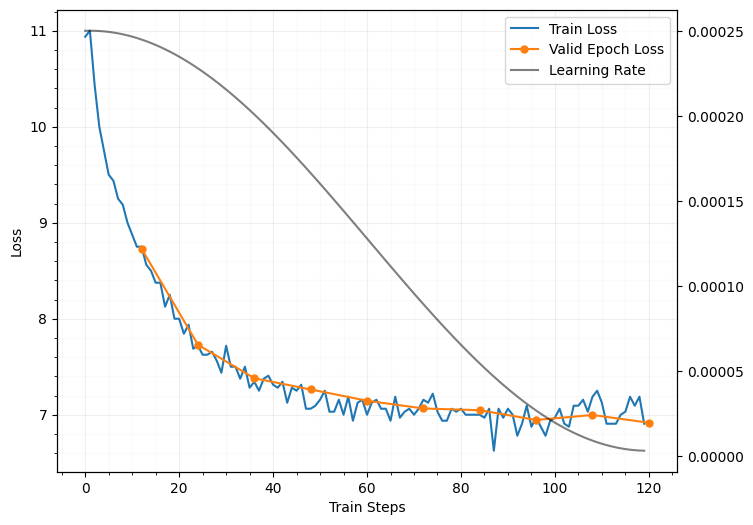

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(logs["losses"], label="Train Loss")
ax.plot(valid_epoch_steps, logs["valid_epoch_losses"], marker='o', markersize=5, label="Valid Epoch Loss")

ax2 = ax.twinx()
ax2.plot(logs["lrs"], color="black", alpha=0.5, label="Learning Rate")

# Combine ax and ax2 legends.
handles = []
labels = []
for a in [ax, ax2]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
ax.legend(handles, labels)

ax.set_xlabel("Train Steps")
ax.set_ylabel("Loss")

ax.grid(which="major", alpha=0.20)
ax.minorticks_on()
ax.grid(which="minor", alpha=0.05)

plt.show()